In [1]:
import torch

checkpoint_path = '../results/2024-04-20-11-54-23-475-morse_sio2/checkpoint_0/best_checkpoint.pt'
state_dict = torch.load(checkpoint_path)['state_dict']

In [2]:
state_dict.keys()

odict_keys(['rm.weight', 'sigmas.weight', 'D.weight', 'base_atomic_energy.weight', 'distance_expansion.offset'])

In [3]:
rm = state_dict['rm.weight']#(state_dict['rm.13'].item() + state_dict['rm.7'].item()) / 2
D = state_dict['sigmas.weight']#(state_dict['D.13'].item() + state_dict['D.7'].item()) / 2
sigma = state_dict['D.weight']#(state_dict['sigmas.13'].item() + state_dict['sigmas.7'].item()) / 2

In [4]:
rm[7], rm[13], D[7], D[13], sigma[7], sigma[13]

(tensor([1.3238], device='cuda:0'),
 tensor([1.8841], device='cuda:0'),
 tensor([4.0594], device='cuda:0'),
 tensor([2.7830], device='cuda:0'),
 tensor([2.3324], device='cuda:0'),
 tensor([2.7030], device='cuda:0'))

In [5]:
rm = ((rm[7] + rm[13]) / 2).item()
D = ((D[7] + D[13]) / 2).item()
sigma = ((sigma[7] + sigma[13]) / 2).item()

In [6]:
rm, D, sigma

(1.6039557456970215, 3.4211783409118652, 2.5177040100097656)

In [7]:
def cutoff_function(r, rc, ro):
    s = 1.0 - (r - rc) / (ro - rc)
    return (s >= 1.0) + (((0.0 < s) & (s < 1.0)) *
                        (6.0 * s**5 - 15.0 * s**4 + 10.0 * s**3))

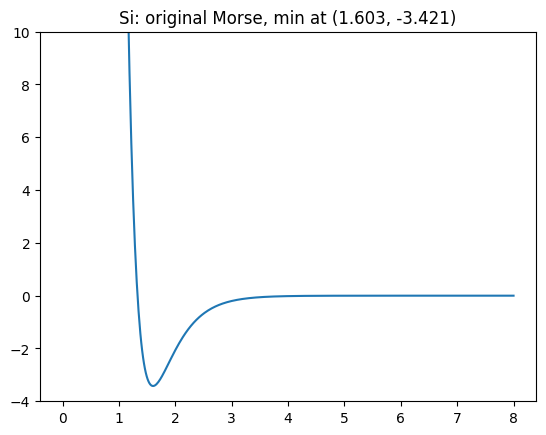

In [8]:
import numpy as np
import matplotlib.pyplot as plt

rc = 8.
ro = 0.66 * rc
X = np.linspace(0, 8., 500)
fc = cutoff_function(X, ro, rc)
    
y = D * (1 - np.exp(-sigma * (X - rm))) ** 2 - D

min_y = np.min(y)
min_x = X[np.where(y == min_y)]

plt.plot(X, y)
plt.ylim(top=10, bottom=-4)
plt.title(f'Si: original Morse, min at ({min_x[0]:.3f}, {min_y:.3f})');

In [55]:
import json

with open('../data/Silica_data/raw/data.json', 'r') as f:
    all_data = json.load(f)
    
len(all_data)

2864

In [62]:
with open('../data/perturbed_silica/raw.json', 'r') as f:
    perturbed_data = json.load(f)

len(perturbed_data)

5728

In [56]:
import numpy as np

structure_ids = [d['structure_id'] for d in all_data]
positions = [np.array(d['positions']) for d in all_data]
cells = [np.array(d['cell']) for d in all_data]
atomic_numbers = [np.array(d['atomic_numbers']) for d in all_data]

In [57]:
import numpy as np

def perturb_positions(pos, distance, min_distance=None):
    random_vectors = np.random.randn(pos.shape[0], 3)
    random_vectors /= np.linalg.norm(random_vectors, axis=1, keepdims=True)
    
    if min_distance is not None:
        perturbation_distances = np.random.uniform(min_distance, distance, size=pos.shape[0])
    else:
        perturbation_distances = np.full((pos.shape[0],), distance)
    
    return pos + perturbation_distances.reshape(-1, 1) * random_vectors

In [58]:
np.random.seed(123456)
perturbed_positions_1 = [perturb_positions(pos, 0.3) for pos in positions]
perturbed_positions_2 = [perturb_positions(pos, 0.3) for pos in positions]

In [59]:
from ase import Atoms
from ase.cell import Cell

atoms_list_1 = [Atoms(
                symbols=atomic_numbers[i],
                positions=perturbed_positions_1[i],
                cell=Cell(cells[i])) for i in range(len(all_data))]
for i in range(len(all_data)):
    atoms_list_1[i].structure_id = structure_ids[i] + '_1'
    
atoms_list_2 = [Atoms(
                symbols=atomic_numbers[i],
                positions=perturbed_positions_2[i],
                cell=Cell(cells[i])) for i in range(len(all_data))]
for i in range(len(all_data)):
    atoms_list_2[i].structure_id = structure_ids[i] + '_2'

In [60]:
from matdeeplearn.common.ase_utils import MDLCalculator

calc = MDLCalculator('../configs/calculator/config_morse.yml', 'cuda:2')

INFO:root:MDLCalculator instantiated from config: ../configs/calculator/config_morse.yml
INFO:root:MDLCalculator: setting up Morse for calculation
INFO:root:MDLCalculator: weights for model No.1 loaded from ../results/2024-04-20-11-54-23-475-morse_sio2/checkpoint_0/best_checkpoint.pt


In [61]:
energy_1, forces_1, stress_1 = [], [], []

for atoms in atoms_list_1:
    calc.calculate(atoms)
    energy_1.append(calc.results['energy'])
    forces_1.append(calc.results['forces'])
    stress_1.append(calc.results['stress'])

In [62]:
energy2, forces2, stress2 = [], [], []

for atoms in atoms_list_2:
    calc.calculate(atoms)
    energy2.append(calc.results['energy'])
    forces2.append(calc.results['forces'])
    stress2.append(calc.results['stress'])

In [63]:
all_perturbed_data = []

for i in range(len(all_data)):
    all_perturbed_data.append({
        'structure_id': structure_ids[i] + '_1',
        'positions': perturbed_positions_1[i].tolist(),
        'cell': cells[i].tolist(),
        'atomic_numbers': atomic_numbers[i].tolist(),
        'y': energy_1[i].item(),
        'forces': forces_1[i].tolist(),
        'stress': [stress_1[i].tolist()]
    })
    
for i in range(len(all_data)):
    all_perturbed_data.append({
        'structure_id': structure_ids[i] + '_2',
        'positions': perturbed_positions_2[i].tolist(),
        'cell': cells[i].tolist(),
        'atomic_numbers': atomic_numbers[i].tolist(),
        'y': energy2[i].item(),
        'forces': forces2[i].tolist(),
        'stress': [stress2[i].tolist()]
    })

In [10]:
import os

os.makedirs('../data/perturbed_silica_0.5', exist_ok=True)

In [11]:
with open('../data/perturbed_silica_0.1/raw.json', 'w') as file:
    json.dump(all_perturbed_data, file)

In [64]:
all_forces = np.vstack((np.vstack(forces_1), np.vstack(forces2)))
all_forces_magnitude = np.linalg.norm(all_forces, axis=1)
all_forces_magnitude.shape

(533716,)

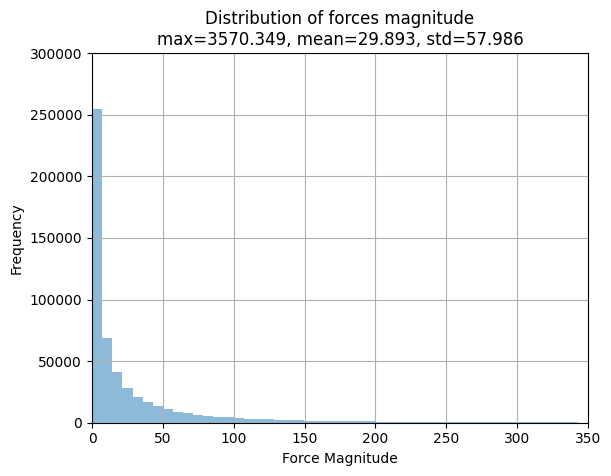

In [84]:
import matplotlib.pyplot as plt

plt.hist(all_forces_magnitude, bins=500, alpha=0.5)
plt.title(f'Distribution of forces magnitude\nmax={np.max(all_forces_magnitude):.3f}, mean={np.mean(all_forces_magnitude):.3f}, std={np.std(all_forces_magnitude):.3f}')
plt.xlim(left=-0.1, right=350)
plt.ylim(top=300000)
plt.xlabel('Force Magnitude')
plt.ylabel('Frequency')
plt.grid(True)
plt.show();

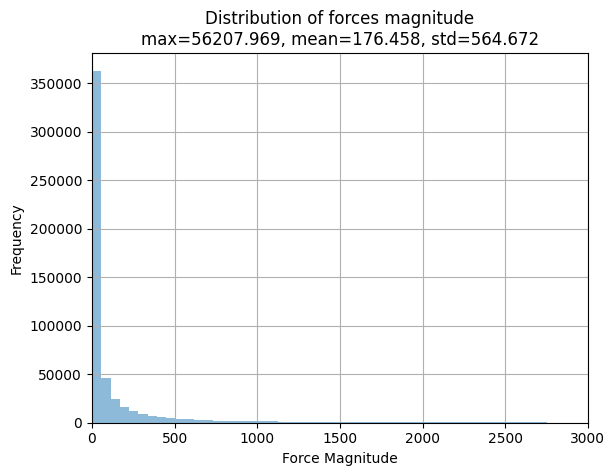

In [54]:
import matplotlib.pyplot as plt

plt.hist(all_forces_magnitude, bins=1000, alpha=0.5)
plt.title(f'Distribution of forces magnitude\nmax={np.max(all_forces_magnitude):.3f}, mean={np.mean(all_forces_magnitude):.3f}, std={np.std(all_forces_magnitude):.3f}')
plt.xlim(left=-0.1, right=3000)
plt.xlabel('Force Magnitude')
plt.ylabel('Frequency')
plt.grid(True)
plt.show();